In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

In [3]:
# Number of sources
r=5
# Number of mixtures
M=10
# Number of samples
N=500000
# SNR level
SNR=30 #dB
NoiseAmp=(10**(-SNR/20))*np.sqrt(r)

#Define number of sampling points
n_samples = N
#Degrees of freedom
df = 4

S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = r, size_sources = N , decreasing_correlation = True)
# S = 2* S - 1
#######################################################
#              GENERATE MIXINGS                       #
#######################################################
# Generate Mxr random mixing from i.i.d N(0,1)
Hm=np.random.randn(M,r)
# Mixtures
HS=np.dot(Hm,S)
NoisePart=NoiseAmp*np.random.randn(HS.shape[0],HS.shape[1])
X=HS+NoisePart
SNRinp=10*np.log10(np.sum(np.var(HS,axis=1))/np.sum(np.var(NoisePart,axis=1)))

# Mean of Mixtures
mX=np.mean(X,axis=1).reshape((M,1))
# Covariance of Mixtures
Rxx=np.dot(X,X.T)/N-np.dot(mX,mX.T)
# Eigenvalue Decomposition
d,V=np.linalg.eig(Rxx)
D=np.diag(d)
#Sorting indexis for eigenvalues from large to small
ie=np.argsort(-d)
# Inverse square root of eigenvalues
ddinv=1/np.sqrt(d[ie[:r]])
# Prewhitining matrix
Wpre=np.dot(np.diag(ddinv),V[:,ie[:r]].T)/np.sqrt(12)
# Whitened Mixtures
H=np.dot(Wpre,X)

In [4]:
muW = 2e-3
p = .3
bet = 0.1

debug_iteration_point = 500

model = OnlineWhiten(s_dim = r, x_dim = M, muW = muW, p = p, bet = bet)

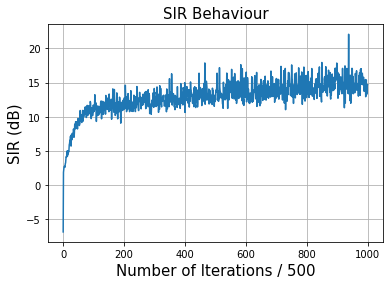

100%|██████████████████████████████████| 500000/500000 [35:25<00:00, 235.22it/s]


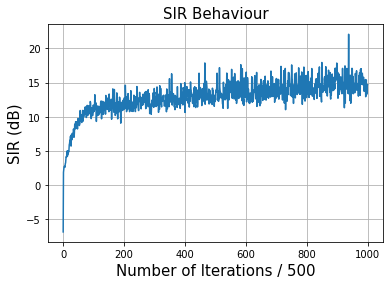

In [5]:
model.fit_batch_whiten(X = X, n_epochs = 1, neural_dynamic_iterations = 1550, neural_lr_start = .3, 
                       neural_lr_stop = 1e-3, shuffle = True, required_SIR = 90,
                       debug_iteration_point = debug_iteration_point, plot_in_jupyter = True)

In [6]:
model.W

array([[ 0.04435229, -0.0028506 ,  0.03245991, -0.00367706,  0.02324842],
       [-0.00972444, -0.00334484, -0.03183622,  0.0479071 ,  0.01328267],
       [ 0.01787476, -0.0454894 , -0.01829213,  0.00190798, -0.00080168],
       [-0.0267672 ,  0.05367279,  0.05648277, -0.01204333,  0.01718738],
       [ 0.01666109,  0.04044665,  0.00212641, -0.00456237, -0.01302248],
       [ 0.00283464,  0.03494143, -0.00344672,  0.00373889,  0.02915069],
       [-0.00727655,  0.00020522, -0.04010176,  0.00954433, -0.01705349],
       [ 0.04880396, -0.00874684,  0.00718988, -0.02774123,  0.00977699],
       [ 0.03302257,  0.02883039, -0.00510102, -0.01425067,  0.0193404 ],
       [-0.01814386, -0.01144735,  0.03676494, -0.0681082 , -0.00254714]])

In [7]:
W = model.compute_overall_mapping()
W

array([[-0.03866287,  0.00405516, -0.00774025,  0.01444255, -0.02080376,
        -0.00967186,  0.00604384, -0.03856114, -0.03286864,  0.02460183],
       [-0.00105603,  0.00510337,  0.04649447, -0.05102344, -0.04887044,
        -0.03513013, -0.0019513 ,  0.00349207, -0.03434685,  0.01821205],
       [-0.0348187 ,  0.02960976,  0.01829373, -0.05788107, -0.0010167 ,
         0.00214997,  0.04180673, -0.0068127 ,  0.00509114, -0.03410864],
       [-0.00187487, -0.05312101, -0.00139317,  0.01176997,  0.00203525,
        -0.00573934, -0.00824249,  0.02736885,  0.01251248,  0.07983498],
       [-0.02158067, -0.00904289, -0.00496896, -0.00863241,  0.01516407,
        -0.01826578,  0.01576739, -0.01053763, -0.01202669, -0.00096233]])

In [8]:
display_matrix(np.corrcoef(X))

<IPython.core.display.Math object>

In [9]:
display_matrix(np.corrcoef(model.Winv @ X))

<IPython.core.display.Math object>

In [10]:
display_matrix(np.corrcoef(W @ X))

<IPython.core.display.Math object>

In [11]:
np.std((model.Winv @ X) / np.std(model.Winv @ X, axis = 1).reshape(-1, 1), axis = 1)

array([1., 1., 1., 1., 1.])

In [12]:
X_ = (model.Winv @ X) / np.std(model.Winv @ X, axis = 1).reshape(-1, 1)
display_matrix(np.corrcoef(X_))

<IPython.core.display.Math object>

In [13]:
np.std(X, axis = 1)

array([0.33315177, 1.07367415, 0.58172083, 0.56242097, 0.80562561,
       0.42724351, 0.48957158, 0.69176387, 0.75184778, 0.46728864])